In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-storm-4/Data-dictionary.xlsx
/kaggle/input/data-storm-4/DataStorm4.0_KaggleProblemStatement.pdf
/kaggle/input/data-storm-4/Store-info.csv
/kaggle/input/data-storm-4/Testing-data.csv
/kaggle/input/data-storm-4/Historical-transaction-data.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold

store_info_data = pd.read_csv('/kaggle/input/data-storm-4/Store-info.csv')
historical_data = pd.read_csv('/kaggle/input/data-storm-4/Historical-transaction-data.csv')
testing_data = pd.read_csv('/kaggle/input/data-storm-4/Testing-data.csv')

print(store_info_data.head())
print(historical_data.head())
print(testing_data.head())

   shop_id  shop_area_sq_ft shop_profile
0  SHOP047              528     Moderate
1  SHOP009              676         High
2  SHOP083              676          Low
3  SHOP117              676          Low
4  SHOP042              676          Low
        item_description          transaction_date  invoice_id customer_id  \
0     ORANGE BARLEY 1.5L  2021-12-11T00:00:00.000Z       147.0        BGXA   
1       GINGER BEER 1.5L  2021-10-17T00:00:00.000Z       371.0        IA25   
2        TONIC PET 500ML  2021-12-13T00:00:00.000Z       484.0        VN7V   
3          CREAM SODA 1L  2021-12-13T00:00:00.000Z       484.0        VN7V   
4  STRAWBERRY MILK 180ML  2021-10-23T00:00:00.000Z      1310.0        7S00   

   shop_id  item_price  quantity_sold  
0  SHOP008         220              2  
1  SHOP112         220              2  
2  SHOP008         160              2  
3  SHOP008         150              2  
4  SHOP112         210              5  
   shop_id  shop_profile
0  SHOP046          

In [5]:
historical_data.isna().sum()

item_description    35928
transaction_date        0
invoice_id           6320
customer_id             0
shop_id                 0
item_price              0
quantity_sold           0
dtype: int64

In [6]:
hd = historical_data.copy()
len(hd) - len(hd.drop_duplicates())

31211

In [7]:
hd. nunique()

item_description        37
transaction_date        62
invoice_id          343342
customer_id         191636
shop_id                124
item_price             209
quantity_sold           69
dtype: int64

In [8]:
hd[(hd['quantity_sold']==0)]

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold
54,CREAM SODA 500ML,2021-12-09T00:00:00.000Z,24423.0,E5FE,SHOP003,100,0
103,SODA 500ML,2021-10-31T00:00:00.000Z,31745.0,ZJY2,SHOP090,70,0
230,CREAM SODA 1.5L,2021-12-10T00:00:00.000Z,52904.0,57RR,SHOP040,220,0
273,NECTO 1.5L,2021-11-12T00:00:00.000Z,59336.0,UVU7,SHOP103,220,0
465,LEMONADE 500ML,2021-11-10T00:00:00.000Z,111021.0,K58C,SHOP032,100,0
...,...,...,...,...,...,...,...
473838,CREAM SODA 1.5L,2021-11-29T00:00:00.000Z,NaN,ZEVD,SHOP021,220,0
473863,FIT O MANGO 1L,2021-10-16T00:00:00.000Z,NaN,M0LJ,SHOP101,290,0
473884,CREAM SODA 1.5L,2021-10-27T00:00:00.000Z,NaN,UARW,SHOP072,220,0
473913,CREAM SODA 500ML,2021-12-09T00:00:00.000Z,NaN,N0BG,SHOP027,100,0


**DUPLICATES**

    Need to try with duplicates in the invoice intact and with the duplicates dropped.

**ZERO QUANTITY**

	Need to be dropped.

In [9]:
# Keeping duplicates and proceeding
# Assuming that duplicates are multiple items in the same bill
indexQuantity = historical_data[(historical_data['quantity_sold'] == 0)].index
historical_data.drop(indexQuantity,inplace = True)

In [10]:
#historical_data.drop(indexQuantity,inplace = True)

In [11]:
len(historical_data) - len(hd)

-8339

In [12]:
shops = hd.groupby(['shop_id'])
num_invs_per_shop = {}

for i in shops:
    num_invs_per_shop[i[0]] = i[1]['invoice_id'].nunique()
    
    
    print(i[0], end = ' - ')
    print(i[1]['invoice_id'].nunique())
    
    

SHOP001 - 1537
SHOP002 - 3769
SHOP003 - 2867
SHOP004 - 2641
SHOP005 - 3183
SHOP006 - 2886
SHOP007 - 2903
SHOP008 - 203
SHOP009 - 3493
SHOP010 - 3437
SHOP011 - 4854
SHOP012 - 1869
SHOP013 - 2798
SHOP014 - 3351
SHOP015 - 2400
SHOP016 - 4477
SHOP017 - 3045
SHOP018 - 3972
SHOP019 - 3045
SHOP020 - 3537
SHOP021 - 2631
SHOP022 - 2408
SHOP023 - 3138
SHOP024 - 2302
SHOP025 - 2628
SHOP026 - 3316
SHOP027 - 2718
SHOP028 - 2827
SHOP029 - 2875
SHOP030 - 2779
SHOP031 - 2821
SHOP032 - 2167
SHOP033 - 3955
SHOP034 - 1844
SHOP035 - 1780
SHOP036 - 2997
SHOP037 - 2990
SHOP038 - 2597
SHOP039 - 3413
SHOP040 - 2418
SHOP041 - 2482
SHOP042 - 2495
SHOP043 - 4986
SHOP044 - 2082
SHOP045 - 3459
SHOP046 - 2735
SHOP047 - 1302
SHOP048 - 2178
SHOP049 - 3040
SHOP050 - 3159
SHOP051 - 3230
SHOP052 - 3423
SHOP053 - 3237
SHOP054 - 2232
SHOP055 - 1915
SHOP056 - 4320
SHOP057 - 1986
SHOP058 - 4128
SHOP059 - 3601
SHOP060 - 2895
SHOP061 - 2345
SHOP062 - 4075
SHOP063 - 2999
SHOP065 - 2550
SHOP066 - 2533
SHOP067 - 2554
SHOP068 - 3

In [13]:
store_info_data[(store_info_data['shop_id']=='SHOP008')]

,shop_id,shop_area_sq_ft,shop_profile
51,SHOP008,678,Moderate


In [14]:
historical_data.describe()

,invoice_id,item_price,quantity_sold
count,4.594190e+05,465635.000000,465635.000000
mean,1.996392e+06,207.492564,1.959990
std,1.344602e+06,167.876200,1.628485
min,1.700000e+01,35.000000,-1.000000
25%,1.031958e+06,100.000000,1.000000
50%,2.032760e+06,200.000000,2.000000
75%,3.032256e+06,220.000000,2.000000
max,8.331754e+06,17400.000000,101.000000


In [15]:
historical_data['total_price'] = historical_data['quantity_sold'] * historical_data['item_price']

shop_wise_features = historical_data.groupby('shop_id').agg(
     invoice_count = ('invoice_id',pd.Series.nunique),
     customer_count = ('customer_id',pd.Series.nunique),
     item_count = ('quantity_sold', 'sum'),
     total_sales = ('total_price', 'sum')
     ).reset_index()
# shop_wise_features.head()

dataset = pd.merge(store_info_data, shop_wise_features, on='shop_id', how='outer')
dataset.head()

,shop_id,shop_area_sq_ft,shop_profile,invoice_count,customer_count,item_count,total_sales
0,SHOP047,528,Moderate,1285,920,3288,842960
1,SHOP009,676,High,3457,2476,8411,1970870
2,SHOP083,676,Low,2675,1876,6644,1691985
3,SHOP117,676,Low,3121,2015,8073,2325980
4,SHOP042,676,Low,2466,1826,5844,1340215


In [16]:
dataset.describe()

,shop_area_sq_ft,invoice_count,customer_count,item_count,total_sales
count,124.000000,124.000000,124.000000,124.000000,1.240000e+02
mean,619.991935,2870.564516,1992.758065,7360.000000,2.152114e+06
std,126.770165,818.898817,562.809783,2168.576664,7.953239e+05
min,298.000000,200.000000,187.000000,502.000000,1.312450e+05
25%,553.250000,2368.250000,1607.250000,5857.250000,1.639405e+06
50%,617.000000,2856.500000,2010.500000,7230.500000,2.062812e+06
75%,676.000000,3389.000000,2397.500000,8694.750000,2.617150e+06
max,1077.000000,4912.000000,3462.000000,13394.000000,6.051205e+06


In [17]:
dataset[(dataset['shop_id']=='SHOP008')]

,shop_id,shop_area_sq_ft,shop_profile,invoice_count,customer_count,item_count,total_sales
51,SHOP008,678,Moderate,200,187,502,131245


In [18]:
dataset['InvoiceCount_Category'] = pd.cut(dataset['invoice_count'], bins=list(range(0,5001,500)))

<AxesSubplot:xlabel='InvoiceCount_Category', ylabel='count'>

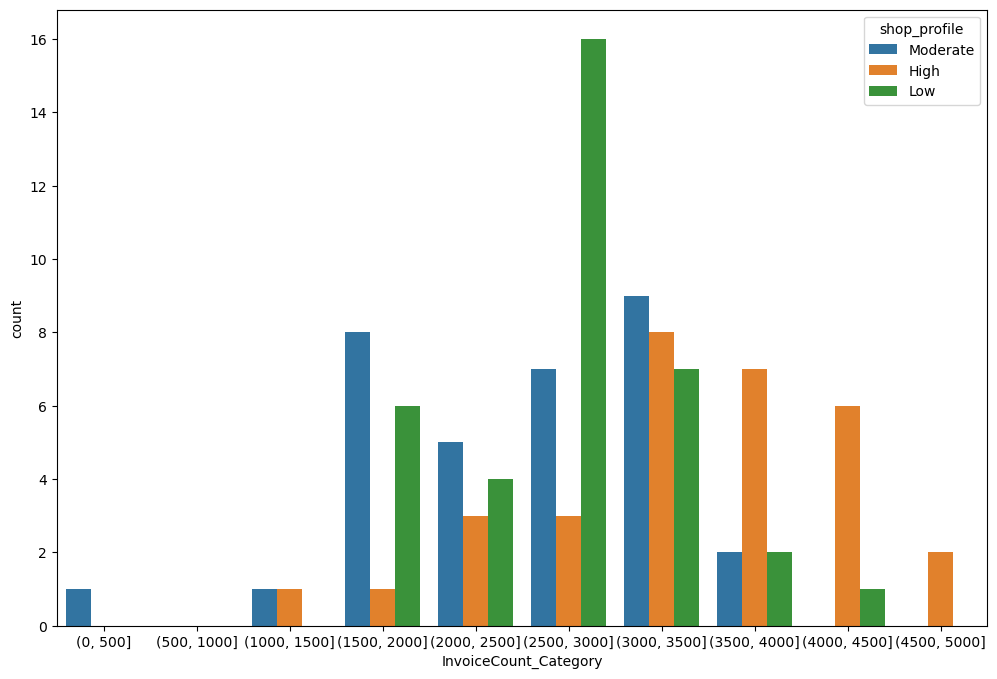

In [19]:
plt.figure(figsize=(12, 8))
sns.countplot(x = 'InvoiceCount_Category', data= dataset, hue='shop_profile')

<AxesSubplot:xlabel='CustomerCount_Category', ylabel='count'>

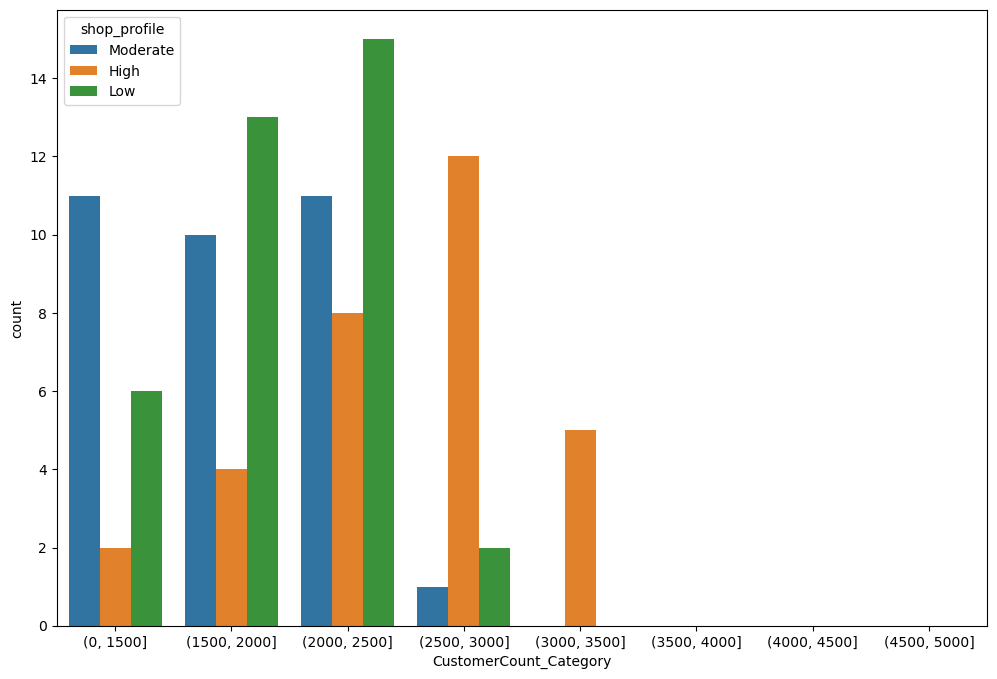

In [20]:
from sklearn.preprocessing import OrdinalEncoder

dataset['CustomerCount_Category'] = pd.cut(dataset['customer_count'], bins=[0]+list(range(1500,5001,500)))

plt.figure(figsize=(12, 8))
sns.countplot(x = 'CustomerCount_Category', data= dataset, hue='shop_profile')

<AxesSubplot:xlabel='Area_Category', ylabel='count'>

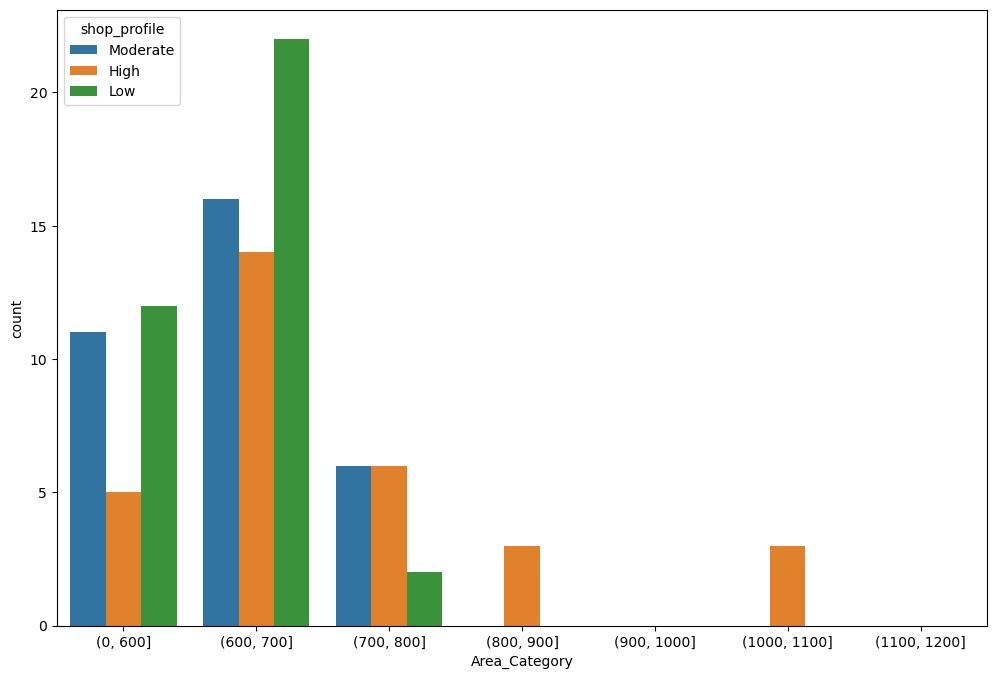

In [21]:
dataset['Area_Category'] = pd.cut(dataset['shop_area_sq_ft'], bins=[0]+list(range(600,1201,100)))

plt.figure(figsize=(12, 8))
sns.countplot(x = 'Area_Category', data= dataset, hue='shop_profile')

<AxesSubplot:xlabel='ItemCount_Category', ylabel='count'>

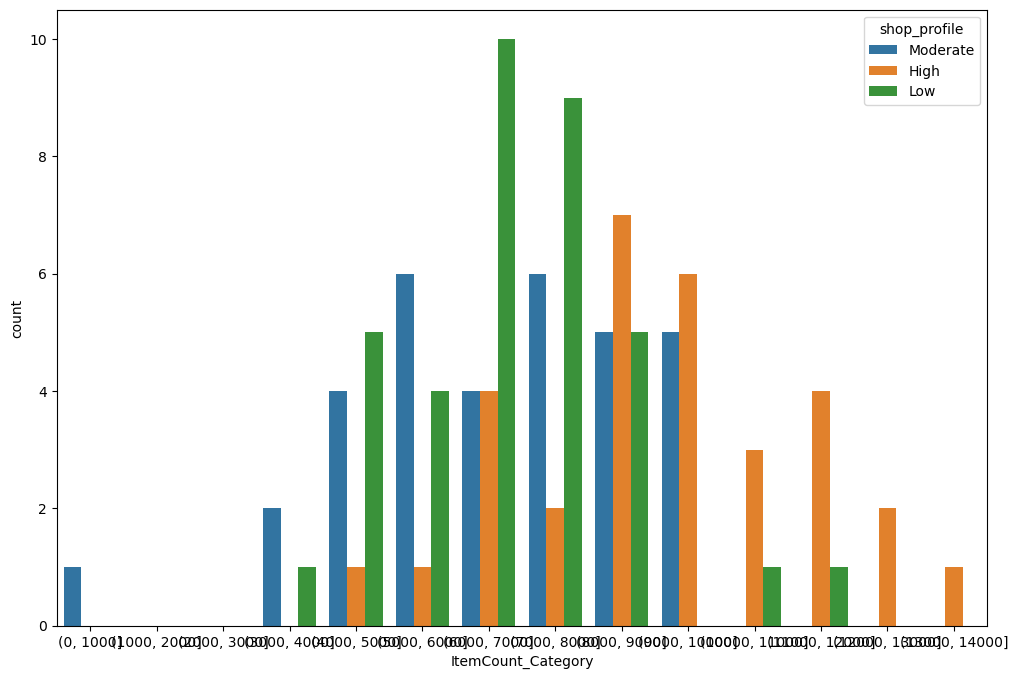

In [22]:
dataset['ItemCount_Category'] = pd.cut(dataset['item_count'], bins=list(range(0,14001,1000)))

plt.figure(figsize=(12, 8))
sns.countplot(x = 'ItemCount_Category', data= dataset, hue='shop_profile')

In [23]:
6.051205e+06

6051205.0

In [24]:
dataset['total_sales'] = dataset['total_sales']/10000

In [25]:
dataset.describe()

,shop_area_sq_ft,invoice_count,customer_count,item_count,total_sales
count,124.000000,124.000000,124.000000,124.000000,124.000000
mean,619.991935,2870.564516,1992.758065,7360.000000,215.211448
std,126.770165,818.898817,562.809783,2168.576664,79.532387
min,298.000000,200.000000,187.000000,502.000000,13.124500
25%,553.250000,2368.250000,1607.250000,5857.250000,163.940500
50%,617.000000,2856.500000,2010.500000,7230.500000,206.281250
75%,676.000000,3389.000000,2397.500000,8694.750000,261.715000
max,1077.000000,4912.000000,3462.000000,13394.000000,605.120500


<AxesSubplot:xlabel='Sales_Category', ylabel='count'>

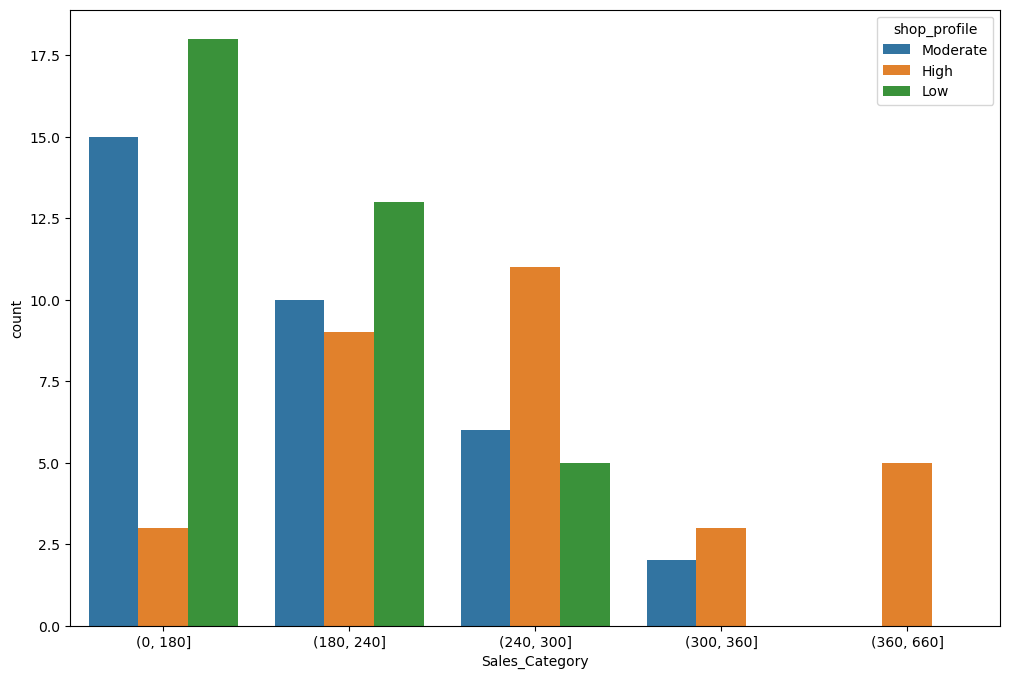

In [26]:
dataset['Sales_Category'] = pd.cut(dataset['total_sales'], bins=[0]+list(range(180,361,60))+[660])

plt.figure(figsize=(12, 8))
sns.countplot(x = 'Sales_Category', data= dataset, hue='shop_profile')

In [27]:
historical_data.describe()

,invoice_id,item_price,quantity_sold,total_price
count,4.594190e+05,465635.000000,465635.000000,4.656350e+05
mean,1.996392e+06,207.492564,1.959990,5.731146e+02
std,1.344602e+06,167.876200,1.628485,3.492484e+03
min,1.700000e+01,35.000000,-1.000000,-2.900000e+02
25%,1.031958e+06,100.000000,1.000000,1.500000e+02
50%,2.032760e+06,200.000000,2.000000,2.400000e+02
75%,3.032256e+06,220.000000,2.000000,4.400000e+02
max,8.331754e+06,17400.000000,101.000000,1.061400e+06


In [28]:
dataset

,shop_id,shop_area_sq_ft,shop_profile,invoice_count,customer_count,item_count,total_sales,InvoiceCount_Category,CustomerCount_Category,Area_Category,ItemCount_Category,Sales_Category
0,SHOP047,528,Moderate,1285,920,3288,84.2960,"(1000, 1500]","(0, 1500]","(0, 600]","(3000, 4000]","(0, 180]"
1,SHOP009,676,High,3457,2476,8411,197.0870,"(3000, 3500]","(2000, 2500]","(600, 700]","(8000, 9000]","(180, 240]"
2,SHOP083,676,Low,2675,1876,6644,169.1985,"(2500, 3000]","(1500, 2000]","(600, 700]","(6000, 7000]","(0, 180]"
3,SHOP117,676,Low,3121,2015,8073,232.5980,"(3000, 3500]","(2000, 2500]","(600, 700]","(8000, 9000]","(180, 240]"
4,SHOP042,676,Low,2466,1826,5844,134.0215,"(2000, 2500]","(1500, 2000]","(600, 700]","(5000, 6000]","(0, 180]"
...,...,...,...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1472,1061,3750,112.8935,"(1000, 1500]","(0, 1500]","(0, 600]","(3000, 4000]","(0, 180]"
120,SHOP050,411,NaN,3119,1765,7668,239.9125,"(3000, 3500]","(1500, 2000]","(0, 600]","(7000, 8000]","(180, 240]"
121,SHOP061,699,NaN,2314,1725,6053,211.0800,"(2000, 2500]","(1500, 2000]","(600, 700]","(6000, 7000]","(180, 240]"
122,SHOP056,597,NaN,4262,2810,11163,302.3805,"(4000, 4500]","(2500, 3000]","(0, 600]","(11000, 12000]","(300, 360]"


In [29]:
dataset['sales/sqft'] = dataset['total_sales']*1000/dataset['shop_area_sq_ft']

In [30]:
dataset.describe()

,shop_area_sq_ft,invoice_count,customer_count,item_count,total_sales,sales/sqft
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,619.991935,2870.564516,1992.758065,7360.000000,215.211448,362.163625
std,126.770165,818.898817,562.809783,2168.576664,79.532387,158.446359
min,298.000000,200.000000,187.000000,502.000000,13.124500,19.357670
25%,553.250000,2368.250000,1607.250000,5857.250000,163.940500,267.158308
50%,617.000000,2856.500000,2010.500000,7230.500000,206.281250,334.957848
75%,676.000000,3389.000000,2397.500000,8694.750000,261.715000,436.695911
max,1077.000000,4912.000000,3462.000000,13394.000000,605.120500,1097.691275


<AxesSubplot:xlabel='Sales/sqft_Category', ylabel='count'>

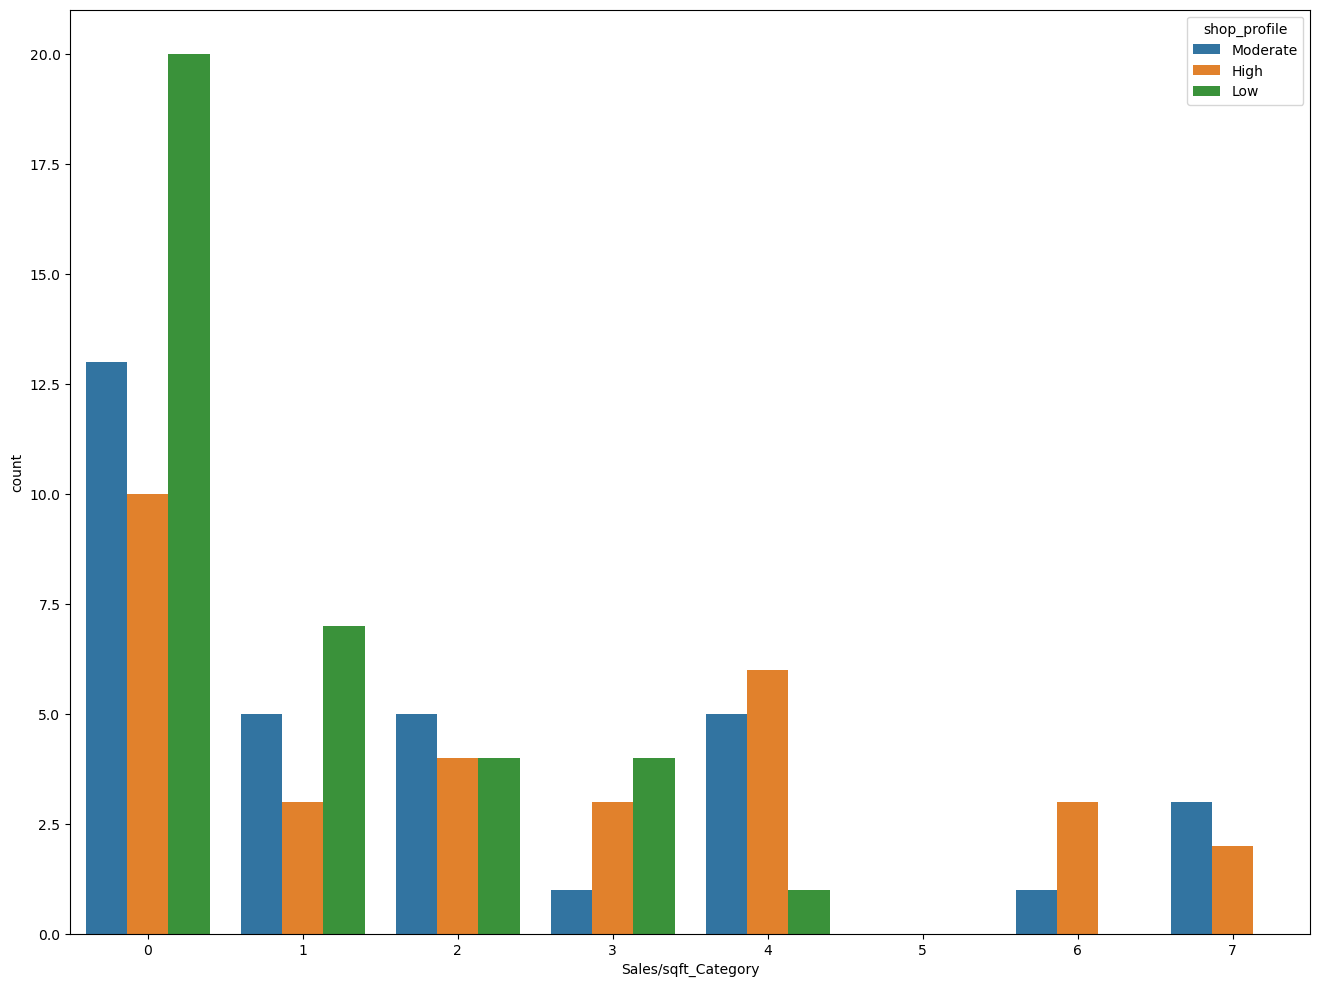

In [31]:
dataset['Sales/sqft_Category'] = pd.cut(dataset['sales/sqft'], bins=[0]+list(range(300,601,50))+[1100], labels=[x for x in range(0,len([0]+list(range(300,601,50))+[1100])-1)])

plt.figure(figsize=(16, 12))
sns.countplot(x = 'Sales/sqft_Category', data= dataset, hue='shop_profile')

In [32]:
dataset['sales/quant'] = dataset['total_sales']*1000/dataset['item_count']

In [33]:
dataset.describe()

,shop_area_sq_ft,invoice_count,customer_count,item_count,total_sales,sales/sqft,sales/quant
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,619.991935,2870.564516,1992.758065,7360.000000,215.211448,362.163625,29.086528
std,126.770165,818.898817,562.809783,2168.576664,79.532387,158.446359,5.236446
min,298.000000,200.000000,187.000000,502.000000,13.124500,19.357670,20.992811
25%,553.250000,2368.250000,1607.250000,5857.250000,163.940500,267.158308,25.781074
50%,617.000000,2856.500000,2010.500000,7230.500000,206.281250,334.957848,28.214401
75%,676.000000,3389.000000,2397.500000,8694.750000,261.715000,436.695911,30.875435
max,1077.000000,4912.000000,3462.000000,13394.000000,605.120500,1097.691275,53.143464


<AxesSubplot:xlabel='Sales/quant_Category', ylabel='count'>

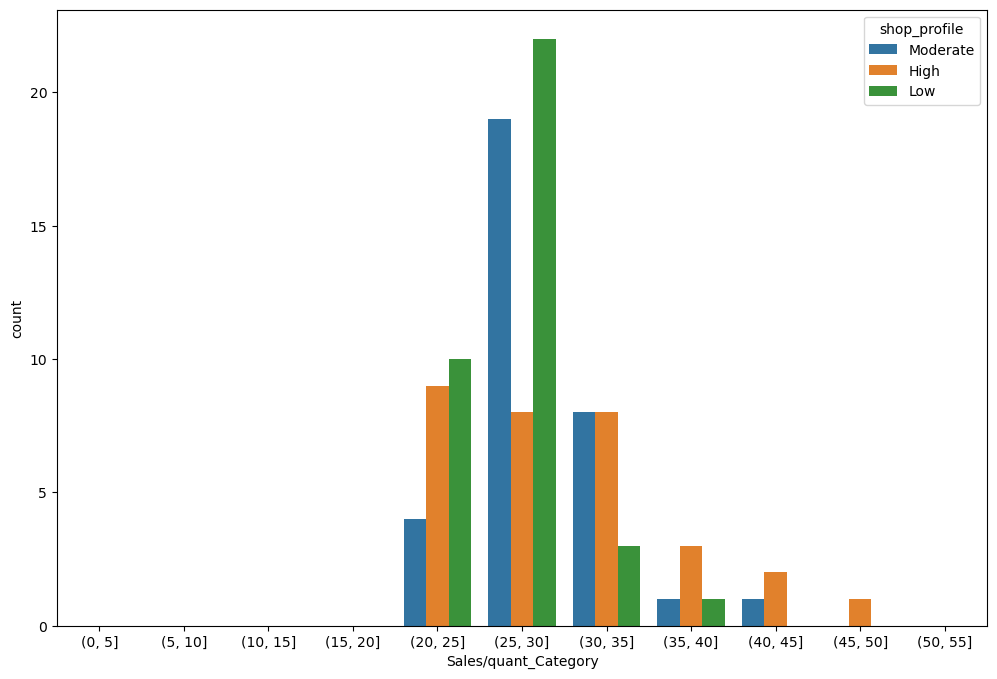

In [34]:
dataset['Sales/quant_Category'] = pd.cut(dataset['sales/quant'], bins=list(range(0,56,5)))

plt.figure(figsize=(12, 8))
sns.countplot(x = 'Sales/quant_Category', data= dataset, hue='shop_profile')

<AxesSubplot:xlabel='shop_profile', ylabel='count'>

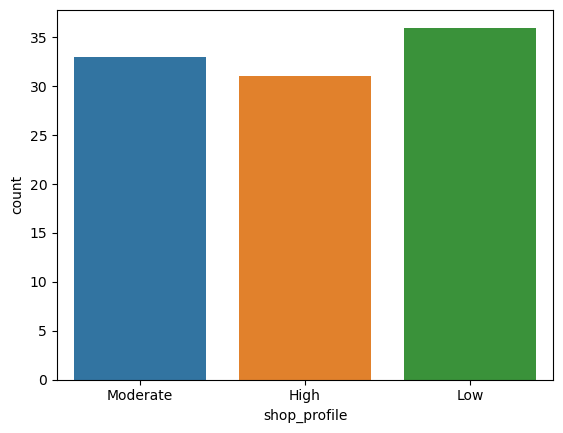

In [35]:
sns.countplot(x='shop_profile', data = dataset)

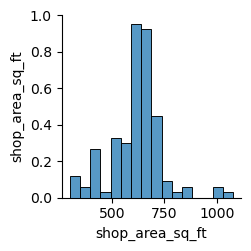

In [36]:
sns.pairplot(data=store_info_data)

**#RESTART**

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold

store_info_data = pd.read_csv('/kaggle/input/data-storm-4/Store-info.csv')
historical_data = pd.read_csv('/kaggle/input/data-storm-4/Historical-transaction-data.csv')
testing_data = pd.read_csv('/kaggle/input/data-storm-4/Testing-data.csv')

print(store_info_data.head())
print(historical_data.head())
print(testing_data.head())

   shop_id  shop_area_sq_ft shop_profile
0  SHOP047              528     Moderate
1  SHOP009              676         High
2  SHOP083              676          Low
3  SHOP117              676          Low
4  SHOP042              676          Low
        item_description          transaction_date  invoice_id customer_id  \
0     ORANGE BARLEY 1.5L  2021-12-11T00:00:00.000Z       147.0        BGXA   
1       GINGER BEER 1.5L  2021-10-17T00:00:00.000Z       371.0        IA25   
2        TONIC PET 500ML  2021-12-13T00:00:00.000Z       484.0        VN7V   
3          CREAM SODA 1L  2021-12-13T00:00:00.000Z       484.0        VN7V   
4  STRAWBERRY MILK 180ML  2021-10-23T00:00:00.000Z      1310.0        7S00   

   shop_id  item_price  quantity_sold  
0  SHOP008         220              2  
1  SHOP112         220              2  
2  SHOP008         160              2  
3  SHOP008         150              2  
4  SHOP112         210              5  
   shop_id  shop_profile
0  SHOP046          

In [38]:
# Keeping duplicates and proceeding
# Assuming that duplicates are multiple items in the same bill
indexQuantity = historical_data[(historical_data['quantity_sold'] == 0)].index
historical_data.drop(indexQuantity,inplace = True)

In [39]:
#Option2 Drop Duplicates
#historical_data.drop_duplicates(inplace=True)

In [40]:
historical_data

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5
...,...,...,...,...,...,...,...
473969,NECTO 1.5L,2021-12-09T00:00:00.000Z,NaN,X21A,SHOP056,440,3
473970,LEMONADE 1.5L,2021-12-02T00:00:00.000Z,NaN,LV2L,SHOP018,220,2
473971,FIT O ORANGE 200ML,2021-11-19T00:00:00.000Z,NaN,VC4O,SHOP077,210,4
473972,CREAM SODA 1.5L,2021-12-03T00:00:00.000Z,NaN,MSBQ,SHOP077,440,3


**Need to clean item_price column for data**

In [41]:
#Check how many null item descriptions correspond to each shop

for i in historical_data.groupby(['shop_id']):
    print(i[0])
    print('length',len(i[1]))
    print(i[1].isna().sum())
    print()

SHOP001
length 1980
item_description    150
transaction_date      0
invoice_id           47
customer_id           0
shop_id               0
item_price            0
quantity_sold         0
dtype: int64

SHOP002
length 4721
item_description    348
transaction_date      0
invoice_id           42
customer_id           0
shop_id               0
item_price            0
quantity_sold         0
dtype: int64

SHOP003
length 3597
item_description    192
transaction_date      0
invoice_id           48
customer_id           0
shop_id               0
item_price            0
quantity_sold         0
dtype: int64

SHOP004
length 3392
item_description    178
transaction_date      0
invoice_id           29
customer_id           0
shop_id               0
item_price            0
quantity_sold         0
dtype: int64

SHOP005
length 4138
item_description    429
transaction_date      0
invoice_id           79
customer_id           0
shop_id               0
item_price            0
quantity_sold         0
dtyp

In [42]:
items = historical_data.groupby('item_description').agg({'item_price' : ['min', pd.Series.mode]})
items

item_price     
                                    min mode
item_description                            
BOTTLED DRINKING WATER 1.5L          70   70
BOTTLED DRINKING WATER 500ML         35   35
CHOCOLATE MILK 180ML                 65  140
CREAM SODA 1.5L                     220  220
CREAM SODA 1L                       150  150
CREAM SODA 500ML                    100  100
CREAM SODA APPLE POP 1L             150  150
DRY GINGER ALE PET 500ML            150  160
FIT O MANGO 1L                      270  290
FIT O MANGO 200ML                    60   60
FIT O MIXED FRUIT 1L                270  290
FIT O MIXED FRUIT 200ML              60   60
FIT O ORANGE 1L                     270  290
FIT O ORANGE 200ML                   60   60
GINGER BEER 1.5L                    220  220
GINGER BEER 1L                      150  150
GINGER BEER 400ML                    80  100
GINGER BEER 500ML                   100  100
GINGER BEER SUGAR FREE 500ML         80   80
KIK COLA 1L                         110  120
LEMONADE 1.5L                       220  220
LEMONADE 1L                         120  120
LEMONADE 500ML                      100  100
LIME CRUSH JUICE 1L                 650  650
NECTO 1.5L                          220  220
NECTO 1L                            150  150
NECTO 500ML                         100  100
ORANGE BARLEY 1.5L                  220  220
ORANGE CRUSH 1.5L                   220  220
ORANGE CRUSH 1L                     150  150
ORANGE CRUSH 500ML                  100  100
SODA 1L                             110  110
SODA 500ML                           70   70
SODA PET 1.5L                       150  160
STRAWBERRY MILK 180ML                65   70
TONIC PET 500ML                     150  160
TWISTEE APPLE 1L                    270  270

In [43]:
items = historical_data.groupby('item_description').agg(mode=('item_price', pd.Series.mode))
items

,mode
item_description,
BOTTLED DRINKING WATER 1.5L,70
BOTTLED DRINKING WATER 500ML,35
CHOCOLATE MILK 180ML,140
CREAM SODA 1.5L,220
CREAM SODA 1L,150
CREAM SODA 500ML,100
CREAM SODA APPLE POP 1L,150
DRY GINGER ALE PET 500ML,160
FIT O MANGO 1L,290


In [44]:
mode_prices = items.to_dict()
modes = mode_prices['mode']

In [45]:
#Remove all null description rows from historicalData 

historical_data.dropna(subset=['item_description'],inplace=True)

In [46]:
historical_data

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5
...,...,...,...,...,...,...,...
473969,NECTO 1.5L,2021-12-09T00:00:00.000Z,NaN,X21A,SHOP056,440,3
473970,LEMONADE 1.5L,2021-12-02T00:00:00.000Z,NaN,LV2L,SHOP018,220,2
473971,FIT O ORANGE 200ML,2021-11-19T00:00:00.000Z,NaN,VC4O,SHOP077,210,4
473972,CREAM SODA 1.5L,2021-12-03T00:00:00.000Z,NaN,MSBQ,SHOP077,440,3


In [47]:
# null_desc = historical_data[historical_data['item_description'].isnull()]
# not_null_desc = historical_data[historical_data['item_description'].notnull()]
# merged = null_desc.merge(not_null_desc.groupby('item_price')['item_description'].value_counts().reset_index(name='count').groupby('item_price').first(), on='item_description', how='left')
# merged = merged.drop('count', axis=1)
# historical_data = pd.concat([not_null_desc, merged])

In [48]:
#Divide all item_price values where item_description is null and item_price greater than 300 by the quantity
# def null_correct(x):
#     if (pd.isna(x.item_description) and x.item_price>300):
#         x.item_price = x.item_price/x.quantity_sold
    
#     return x
        
    
# historical_data = historical_data.apply(null_correct,axis=1)

In [49]:
historical_data[pd.isna(historical_data['item_description'])]

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold


In [50]:
type(0.1)==float

True

In [51]:
#Handle errors in quantity column and item_price column
#Tried to correct errors in recording item price and quantity in the dataset
import math
def replace_quantity(x):
    #print(x)
    if not(pd.isna(x.item_description)):
        if modes[x['item_description']]< x['item_price']:
            #print(x)
            x.quantity_sold = math.ceil(x.item_price/modes[x.item_description])
        x.item_price = modes[x.item_description]
        #x.revenue = modes[x.item_description]
    return x


In [52]:
#Run above function
#historical_data = historical_data.apply(replace_quantity,axis=1)
historical_data=historical_data.apply(replace_quantity,axis=1)

In [53]:
store_info_copy = store_info_data.copy()

RESTART POINT
-Resets store_info_data

In [54]:
store_info_data = store_info_copy

In [55]:
historical_data

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,70,3
...,...,...,...,...,...,...,...
473969,NECTO 1.5L,2021-12-09T00:00:00.000Z,NaN,X21A,SHOP056,220,2
473970,LEMONADE 1.5L,2021-12-02T00:00:00.000Z,NaN,LV2L,SHOP018,220,2
473971,FIT O ORANGE 200ML,2021-11-19T00:00:00.000Z,NaN,VC4O,SHOP077,60,4
473972,CREAM SODA 1.5L,2021-12-03T00:00:00.000Z,NaN,MSBQ,SHOP077,220,2


In [56]:
store_info_data

,shop_id,shop_area_sq_ft,shop_profile
0,SHOP047,528,Moderate
1,SHOP009,676,High
2,SHOP083,676,Low
3,SHOP117,676,Low
4,SHOP042,676,Low
...,...,...,...
119,SHOP087,527,NaN
120,SHOP050,411,NaN
121,SHOP061,699,NaN
122,SHOP056,597,NaN


In [57]:
# Compute total number of unique customers
unique_customers = historical_data.groupby(['shop_id'])['customer_id'].nunique()

unique_customers = unique_customers.rename('unique_customers')

store_info_data = store_info_data.merge(unique_customers, on='shop_id')

In [58]:
# Compute total number of unique transactions
transactions = historical_data.groupby(['shop_id'])['invoice_id'].nunique()

transactions = transactions.rename('transactions')

store_info_data = store_info_data.merge(transactions, on='shop_id')

In [59]:
# Compute total number of unique items
unique_items = historical_data.groupby('shop_id')['item_description'].nunique()

unique_items = unique_items.rename('unique_items')

store_info_data = store_info_data.merge(unique_items, on='shop_id')

In [60]:
# Compute total number of items
items = historical_data.groupby(['shop_id'])['quantity_sold'].sum()

items = items.rename('items')

store_info_data = store_info_data.merge(items, on='shop_id')

In [61]:
# Compute total revenue
historical_data['revenue'] = historical_data['item_price'] * historical_data['quantity_sold']


revenue = historical_data.groupby('shop_id')['revenue'].sum()

revenue = revenue.rename('revenue')

store_info_data = store_info_data.merge(revenue, on='shop_id')

In [62]:
historical_data

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,revenue
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2,440
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2,440
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2,320
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2,300
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,70,3,210
...,...,...,...,...,...,...,...,...
473969,NECTO 1.5L,2021-12-09T00:00:00.000Z,NaN,X21A,SHOP056,220,2,440
473970,LEMONADE 1.5L,2021-12-02T00:00:00.000Z,NaN,LV2L,SHOP018,220,2,440
473971,FIT O ORANGE 200ML,2021-11-19T00:00:00.000Z,NaN,VC4O,SHOP077,60,4,240
473972,CREAM SODA 1.5L,2021-12-03T00:00:00.000Z,NaN,MSBQ,SHOP077,220,2,440


In [63]:
# Compute max item_price
max_item_price = historical_data.groupby('shop_id')['revenue'].max()

max_item_price = max_item_price.rename('max_item_price')

store_info_data = store_info_data.merge(max_item_price, on='shop_id')

In [64]:
store_info_data

,shop_id,shop_area_sq_ft,shop_profile,unique_customers,transactions,unique_items,items,revenue,max_item_price
0,SHOP047,528,Moderate,840,1159,35,2734,418635,2200
1,SHOP009,676,High,2219,3052,35,6822,1079155,2610
2,SHOP083,676,Low,1711,2436,36,5634,929840,3080
3,SHOP117,676,Low,1893,2912,35,6941,1106825,1600
4,SHOP042,676,Low,1664,2229,35,4931,790450,2640
...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1002,1376,35,3298,549650,3360
120,SHOP050,411,NaN,1695,2980,31,6670,1158200,2640
121,SHOP061,699,NaN,1655,2214,35,5428,901730,4500
122,SHOP056,597,NaN,2663,3969,35,9393,1478310,2640


In [65]:
# Compute min item_price
min_item_price = historical_data.groupby('shop_id')['item_price'].max()

min_item_price = min_item_price.rename('min_item_price')

#store_info_data = store_info_data.merge(min_item_price, on='shop_id')

In [66]:
# Compute max quantity_sold
max_quantity_sold = historical_data.groupby('shop_id')['quantity_sold'].max()

max_quantity_sold = max_quantity_sold.rename('max_quantity_sold')

store_info_data = store_info_data.merge(max_quantity_sold, on='shop_id')

In [67]:
# Compute min quantity_sold
min_quantity_sold = historical_data.groupby('shop_id')['quantity_sold'].min()

min_quantity_sold = min_quantity_sold.rename('min_quantity_sold')

store_info_data = store_info_data.merge(min_quantity_sold, on='shop_id')

In [68]:
# Compute avg price
# Average price of item (revenue/quantity)
price = revenue / items

price = price.rename('price')

#store_info_data = store_info_data.merge(price, on='shop_id')

In [69]:
#Sales per sqft

store_info_data['spsf'] = store_info_data['revenue']/store_info_data['shop_area_sq_ft']



In [70]:
#Average transaction value

store_info_data['avg_transaction'] = store_info_data['revenue']/store_info_data['transactions']

In [71]:
#Revenue per day
store_info_data['revenue_per_day'] = store_info_data['revenue']/61

In [72]:
store_info_data

,shop_id,shop_area_sq_ft,shop_profile,unique_customers,transactions,unique_items,items,revenue,max_item_price,max_quantity_sold,min_quantity_sold,spsf,avg_transaction,revenue_per_day
0,SHOP047,528,Moderate,840,1159,35,2734,418635,2200,22,1,792.869318,361.203624,6862.868852
1,SHOP009,676,High,2219,3052,35,6822,1079155,2610,27,1,1596.383136,353.589450,17691.065574
2,SHOP083,676,Low,1711,2436,36,5634,929840,3080,24,1,1375.502959,381.707718,15243.278689
3,SHOP117,676,Low,1893,2912,35,6941,1106825,1600,24,-1,1637.315089,380.091003,18144.672131
4,SHOP042,676,Low,1664,2229,35,4931,790450,2640,25,1,1169.304734,354.620906,12958.196721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,SHOP087,527,NaN,1002,1376,35,3298,549650,3360,21,1,1042.979127,399.454942,9010.655738
120,SHOP050,411,NaN,1695,2980,31,6670,1158200,2640,24,1,2818.004866,388.657718,18986.885246
121,SHOP061,699,NaN,1655,2214,35,5428,901730,4500,75,1,1290.028612,407.285456,14782.459016
122,SHOP056,597,NaN,2663,3969,35,9393,1478310,2640,44,-1,2476.231156,372.464097,24234.590164


In [73]:
store_info_data.describe()

,shop_area_sq_ft,unique_customers,transactions,unique_items,items,revenue,max_item_price,max_quantity_sold,min_quantity_sold,spsf,avg_transaction,revenue_per_day
count,124.000000,124.000000,124.000000,124.000000,124.000000,1.240000e+02,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,619.991935,1864.403226,2658.911290,34.862903,6270.233871,9.870115e+05,2755.564516,38.798387,0.822581,1654.349910,371.316667,16180.516922
std,126.770165,530.414318,766.686387,1.333342,1859.218872,2.916091e+05,1632.902699,19.428828,0.570955,563.375790,21.543193,4780.477062
min,298.000000,181.000000,194.000000,31.000000,468.000000,7.278500e+04,960.000000,12.000000,-1.000000,107.352507,269.137039,1193.196721
25%,553.250000,1524.250000,2230.500000,35.000000,5114.750000,7.982238e+05,1920.000000,24.000000,1.000000,1246.379983,358.867256,13085.635246
50%,617.000000,1837.000000,2614.500000,35.000000,6162.000000,9.672750e+05,2610.000000,36.000000,1.000000,1636.823603,372.291862,15856.967213
75%,676.000000,2225.250000,3100.000000,36.000000,7467.000000,1.138841e+06,3162.500000,49.250000,1.000000,1999.114017,386.776963,18669.528689
max,1077.000000,3036.000000,4549.000000,36.000000,10984.000000,1.650365e+06,17400.000000,100.000000,1.000000,3178.859060,422.314104,27055.163934


In [74]:
#No of days with above average performance

grps = historical_data.groupby(['shop_id'])
good_day_counts = {}
for grp in grps:
    rpd = store_info_data[(store_info_data['shop_id']==grp[0])].revenue_per_day
    by_day = grp[1].groupby(['transaction_date']).agg(rev_sum=('revenue', 'sum'))
    by_day_count = len(by_day[by_day['rev_sum']>by_day['rev_sum'].mean()])
    good_day_counts[grp[0]] = by_day_count
    #print(by_day[by_day['rev_sum']>by_day['rev_sum'].mean()],by_day['rev_sum'].mean(),rpd)
    #print(grp[0], by_day_count)
    #print(by_day)
#     print(by_day.describe())

In [75]:
#add good day counts to data

store_info_data['good_day_count'] = store_info_data['shop_id']

store_info_data['good_day_count'] = store_info_data['good_day_count'].apply(lambda x:good_day_counts[x])

store_info_data['good_day_count'].value_counts()

27    29
28    21
26    17
29    14
25    13
30     9
31     5
23     5
24     5
22     2
33     2
21     1
2      1
Name: good_day_count, dtype: int64

**Binning**

<AxesSubplot:xlabel='CustomerCount_Category', ylabel='count'>

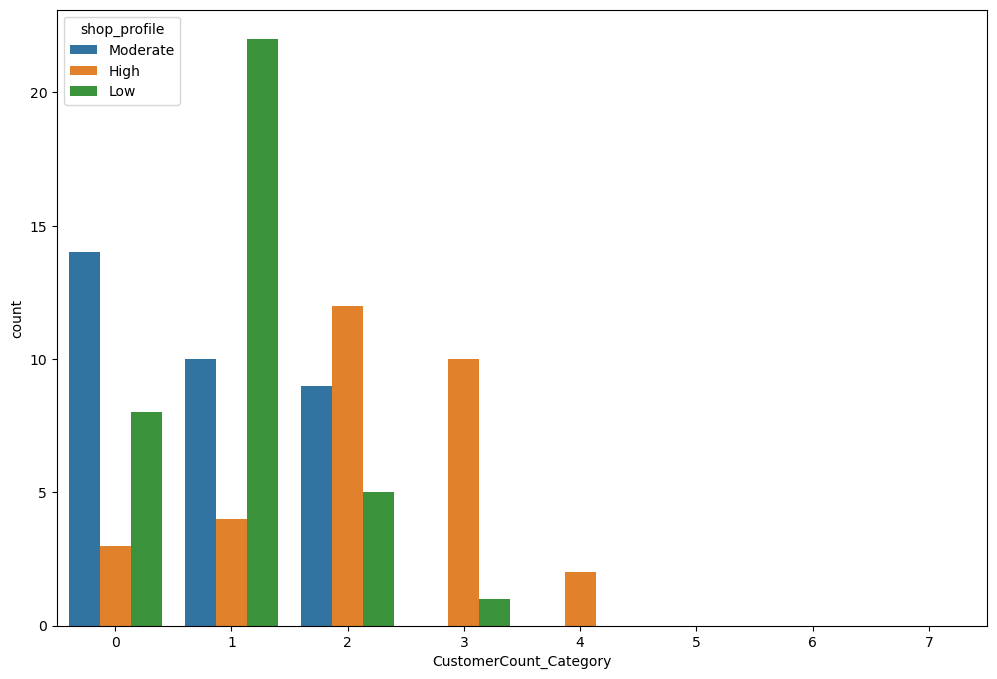

In [76]:
store_info_data['CustomerCount_Category'] = pd.cut(store_info_data['unique_customers'], bins=[0]+list(range(1500,5001,500)),labels=[x for x in range(len([0]+list(range(1500,5001,500)))-1)])

plt.figure(figsize=(12, 8))
sns.countplot(x = 'CustomerCount_Category', data= store_info_data, hue='shop_profile')

**EVALUATION**

In [297]:
store_info_data["shop_profile"] = store_info_data["shop_profile"].replace({"High": 1, "Moderate": 2, "Low": 3})

In [298]:
non_empty_profiles = store_info_data[~store_info_data['shop_profile'].isna()]
empty_profiles = store_info_data[store_info_data['shop_profile'].isna()]

In [299]:
X = non_empty_profiles.drop(columns=["shop_id", "shop_profile",'unique_customers','revenue','transactions','shop_area_sq_ft','CustomerCount_Category','good_day_count'])
y = non_empty_profiles["shop_profile"]

**Results**

X = non_empty_profiles.drop(columns=["shop_id", "shop_profile",'revenue','CustomerCount_Category'])
Gives: (0.8000000000000002, 0.64), (0.7733333333333333, 0.64), (0.7866666666666666, 0.56), (0.76, 0.68)]

X = non_empty_profiles.drop(columns=["shop_id", "shop_profile"])
Gives: Logistic Regression Scores are:  [(0.7333333333333333, 0.6), (0.72, 0.44), (0.6666666666666666, 0.6), (0.7466666666666667, 0.56)]

X = non_empty_profiles.drop(columns=["shop_id", "shop_profile",'revenue'])
Gives: Logistic Regression Scores are:  [(0.8133333333333334, 0.56), (0.76, 0.64), (0.7866666666666666, 0.56), (0.7466666666666667, 0.76)]

X = non_empty_profiles.drop(columns=["shop_id", "shop_profile",'revenue','unique_customers'])
Gives: Logistic Regression Scores are:  [(0.7733333333333333, 0.64), (0.7466666666666667, 0.64), (0.76, 0.6), (0.7466666666666667, 0.68)]

Dropped price = revenue/quantity
Gives: Logistic Regression Scores are:  [(0.7733333333333333, 0.6), (0.7333333333333333, 0.64), (0.8133333333333334, 0.6), (0.8000000000000002, 0.72)]

revenue per day was added (simillar to revenue)
gives: Logistic Regression Scores are:  [(0.7466666666666667, 0.64), (0.7733333333333333, 0.64), (0.8133333333333334, 0.6), (0.76, 0.76)]

 ['unique_items', 'items', 'max_item_price', 'max_quantity_sold', 'min_quantity_sold', 'spsf', 'avg_transaction', 'revenue_per_day']
 Gives: Logistic Reg Classifier scores are :  [(0.6666666666666666, 0.64), (0.6133333333333333, 0.76), (0.6933333333333334, 0.6), (0.72, 0.68)]

In [300]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

scores_l = []
scores_knn = []
scores_svc = []
scores_rfc = []
scores_gnb = []

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=10)

# Get the scores from various models
from sklearn.metrics import f1_score

def get_score (model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    return  f1_score(y_train, y_pred_train, average = 'micro'), f1_score(y_test,y_pred_test, average = 'micro')

from sklearn.preprocessing import StandardScaler,RobustScaler

for train_idx, test_idx in kf.split(X,y):
    
    X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
    
    scores_l.append(get_score(LogisticRegression(max_iter = 5000,random_state=1), X_train, X_test, y_train, y_test))
    scores_knn.append(get_score(KNeighborsClassifier(n_neighbors=18), X_train, X_test, y_train, y_test))
    scores_svc.append(get_score(SVC(), X_train, X_test, y_train, y_test))
    scores_rfc.append(get_score(RandomForestClassifier(30,random_state=1), X_train, X_test, y_train, y_test))
    scores_gnb.append(get_score(GaussianNB(), X_train, X_test, y_train, y_test))

print("Logistic Regression scores are: ", scores_l, "\n")
print("K Nearest Neighbours scores are: ",scores_knn, "\n")
print("Support Vector Machines scores are: ",scores_svc, "\n")
print("Random Forest Classifier scores are: ",scores_rfc, "\n")
print("Gaussian N B scores are: ",scores_gnb, "\n")

Logistic Regression scores are:  [(0.6666666666666666, 0.64), (0.6133333333333333, 0.76), (0.6933333333333334, 0.6), (0.72, 0.68)] 

K Nearest Neighbours scores are:  [(0.6133333333333333, 0.48), (0.5733333333333334, 0.48), (0.56, 0.6), (0.5333333333333333, 0.48)] 

Support Vector Machines scores are:  [(0.4933333333333334, 0.4000000000000001), (0.52, 0.44), (0.5066666666666667, 0.48), (0.4533333333333333, 0.48)] 

Random Forest Classifier scores are:  [(1.0, 0.52), (1.0, 0.52), (1.0, 0.64), (1.0, 0.56)] 

Gaussian N B scores are:  [(0.64, 0.48), (0.64, 0.44), (0.6266666666666667, 0.44), (0.5866666666666667, 0.6)] 



In [301]:
l = [10,1,0.15,0.1,0.05,0.01,0.001]
for n in l:
    scores_l = []
    for train_idx, test_idx in kf.split(X,y):

        X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

        scores_l.append(get_score(LogisticRegression(max_iter = 5000,random_state=1,C=n), X_train, X_test, y_train, y_test))
    print(n)
    print("Logistic Reg Classifier scores are : ",scores_l)
#print(scores_rfc)

10
Logistic Reg Classifier scores are :  [(0.6533333333333333, 0.6), (0.68, 0.64), (0.72, 0.6), (0.7333333333333333, 0.68)]
1
Logistic Reg Classifier scores are :  [(0.6666666666666666, 0.64), (0.6133333333333333, 0.76), (0.6933333333333334, 0.6), (0.72, 0.68)]
0.15
Logistic Reg Classifier scores are :  [(0.6666666666666666, 0.64), (0.64, 0.76), (0.6666666666666666, 0.6), (0.6933333333333334, 0.68)]
0.1
Logistic Reg Classifier scores are :  [(0.68, 0.6), (0.64, 0.64), (0.6666666666666666, 0.64), (0.7066666666666667, 0.68)]
0.05
Logistic Reg Classifier scores are :  [(0.68, 0.6), (0.64, 0.68), (0.6666666666666666, 0.6), (0.6933333333333334, 0.68)]
0.01
Logistic Reg Classifier scores are :  [(0.68, 0.6), (0.6133333333333333, 0.68), (0.6933333333333334, 0.6), (0.72, 0.64)]
0.001
Logistic Reg Classifier scores are :  [(0.7066666666666667, 0.6), (0.6133333333333333, 0.68), (0.6533333333333333, 0.6), (0.6933333333333334, 0.64)]


In [302]:
ss = StandardScaler()

#X_test2 = ss.transform(X_test)


def sub_lists (l):
    lists = [[]]
    for i in range(len(l) + 1):
        for j in range(i):
            lists.append(l[j: i])
    return lists
 
l1 = X.columns.to_list()
combinations = sub_lists(l1)
scores = []
maxi = []
print("combinations", len(combinations), len(l1),l1)
for combination in combinations:
    if(len(combination)>3):
        scores_l = []
        for train_idx, test_idx in kf.split(X,y):

            X_train, X_test, y_train, y_test = X[X.columns.intersection(combination)].iloc[train_idx], X[X.columns.intersection(combination)].iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
            #X_train = ss.fit_transform(X_train)
            #X_test = ss.transform(X_test)
            scores_l.append(get_score(LogisticRegression(max_iter=5000,random_state=1), X_train, X_test, y_train, y_test)[1])
        scores.append(sum(scores_l)/len(scores_l))
        if(sum(scores_l)/len(scores_l) > 0.65):
            print(sum(scores_l)/len(scores_l), combination)
        
print("Logistic Regression Scores are: ", max(scores))
print('\n')

combinations 37 8 ['unique_items', 'items', 'max_item_price', 'max_quantity_sold', 'min_quantity_sold', 'spsf', 'avg_transaction', 'revenue_per_day']
0.67 ['unique_items', 'items', 'max_item_price', 'max_quantity_sold', 'min_quantity_sold', 'spsf', 'avg_transaction', 'revenue_per_day']
Logistic Regression Scores are:  0.67




In [303]:
ss = StandardScaler()
X2 = ss.fit_transform(X)
#X_test2 = ss.transform(X_test)
scores_knn = []
for train_idx, test_idx in kf.split(X2,y):
    
    X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
    
    scores_knn.append(get_score(KNeighborsClassifier(n_neighbors=18), X_train, X_test, y_train, y_test))
    
print("K Nearest Neighbours scores are: ",scores_knn, "\n")
print('\n')

K Nearest Neighbours scores are:  [(0.6133333333333333, 0.48), (0.5733333333333334, 0.48), (0.56, 0.6), (0.5333333333333333, 0.48)] 





In [304]:
#for n in range(2,16):
scores_rfc = []
for train_idx, test_idx in kf.split(X,y):

    X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

    scores_rfc.append(get_score(RandomForestClassifier(70,max_depth=7,min_samples_split=6,random_state=1), X_train, X_test, y_train, y_test))
#print(n)
print("Random Forest Classifier scores are : ",scores_rfc)
#print(scores_rfc)

Random Forest Classifier scores are :  [(0.9333333333333333, 0.48), (0.96, 0.56), (0.96, 0.6), (0.9733333333333334, 0.68)]


**Create New Feature Based on Historical Data**

In [305]:
#How many above average performing days for each store



**Random Forest Classifier Submission Code**

In [306]:
rfc = RandomForestClassifier(70,max_depth=7,min_samples_split=6,random_state=1)
rfc.fit(X,y)

X_test = empty_profiles.drop(columns=["shop_id", "shop_profile", 'revenue','unique_customers'])

y_test = rfc.predict(X_test)

ValueError: X has 12 features, but RandomForestClassifier is expecting 8 features as input.

**Logistic Regression Classifier Submission Code**

In [307]:
LogisticRegression(max_iter=5000)
lr = LogisticRegression(max_iter=5000,random_state=1,C=0.2)
lr.fit(X,y)

X_test = empty_profiles.drop(columns=["shop_id", "shop_profile", 'revenue','unique_customers','transactions','shop_area_sq_ft','CustomerCount_Category','good_day_count'])

y_test = lr.predict(X_test)

In [308]:
y_train_ = lr.predict(X)

f1_score(y,y_train_,average='micro')

0.69

**Get CSV File**

In [309]:
test_preds = pd.DataFrame({'shop_id':empty_profiles['shop_id'],'shop_profile':y_test})


In [310]:
len(test_preds)

24

In [311]:
test_preds

,shop_id,shop_profile
100,SHOP046,2.0
101,SHOP024,3.0
102,SHOP023,3.0
103,SHOP097,2.0
104,SHOP044,3.0
105,SHOP030,2.0
106,SHOP038,2.0
107,SHOP029,2.0
108,SHOP096,3.0
109,SHOP092,2.0


In [312]:
testing_data

,shop_id,shop_profile
0,SHOP046,NaN
1,SHOP024,NaN
2,SHOP023,NaN
3,SHOP097,NaN
4,SHOP044,NaN
5,SHOP030,NaN
6,SHOP038,NaN
7,SHOP029,NaN
8,SHOP096,NaN
9,SHOP092,NaN


In [313]:
test_preds["shop_profile"] = test_preds["shop_profile"].replace({1: 'High',2: "Moderate", 3:"Low"})

In [314]:
test_preds

,shop_id,shop_profile
100,SHOP046,Moderate
101,SHOP024,Low
102,SHOP023,Low
103,SHOP097,Moderate
104,SHOP044,Low
105,SHOP030,Moderate
106,SHOP038,Moderate
107,SHOP029,Moderate
108,SHOP096,Low
109,SHOP092,Moderate


In [315]:
filename = 'DataStorm087_Day3_2.csv'
test_preds.to_csv(filename,index=False)